
Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False

0 IGD 0.21846515442873102
1 IGD 0.20064327599913642
2 IGD 0.16239969084495262
3 IGD 0.1527186457830407
4 IGD 0.12213610609045092
5 IGD 0.1128327629780587
6 IGD 0.10533793527492548
7 IGD 0.09428732513228011
8 IGD 0.08704430064426379
9 IGD 0.08160065559734761
10 IGD 0.08160065559734761
11 IGD 0.07041703077786216
12 IGD 0.06708149240988254
13 IGD 0.06465031089737736
14 IGD 0.06213298737084324
15 IGD 0.06210342681129252
16 IGD 0.06210342681129252
17 IGD 0.0612403783111137
18 IGD 0.0604477021930636
19 IGD 0.0564591066729145
20 IGD 0.05468625587279941
21 IGD 0.05468625587279941
22 IGD 0.05468625587279941
23 IGD 0.054542055150254905
24 IGD 0.05106841159003573
25 IGD 0.050620808820989606
26 IGD 0.050446566566598315
27 IGD 0.050446566566598315
28 IGD 0.04778237740460623
29 IGD 0.046964655960

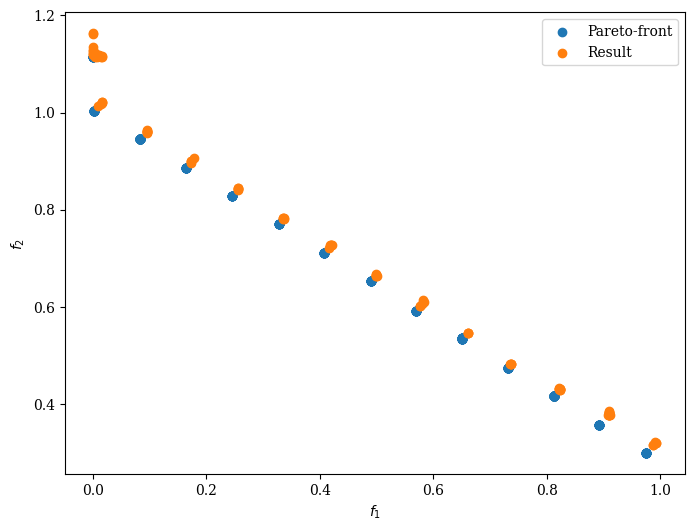

In [1]:
import numpy as np
import random

from pymoo.core.population import Population, pop_from_array_or_individual, merge
from pymoo.core.individual import Individual
from pymoo.core.evaluator import Evaluator
from pymoo.util.dominator import get_relation
from pymoo.problems import get_problem
from pymoo.indicators.igd import IGD
from pymoo.visualization.scatter import Scatter
from pymoode.survival import ConstrRankAndCrowding

problem = get_problem("ctp3", n_var=5)
pf = problem.pareto_front()
ind = IGD(pf)

def softmax(values, T=1.0):
    exp_values = np.exp(values / T)
    return exp_values / np.sum(exp_values)

class Qlearning:
    def __init__(self, num_states, num_actions, alpha=0.1, gamma=0.9):
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.q_table = np.zeros((num_states, num_actions))

    def choose_action(self, state):
        probabilities = softmax(self.q_table[state])
        return np.random.choice(self.num_actions, p=probabilities)

    def update(self, state, action, reward, next_state):
        next_max = np.max(self.q_table[next_state])
        self.q_table[state, action] += self.alpha * (reward + self.gamma * next_max - self.q_table[state, action])


def get_offspring(pop, F, CR, index):
    num_pop = pop.shape[0]
    num_var = pop.shape[1]
    offspring = np.zeros(num_var)
    idxs = np.random.choice(num_pop, 3, replace=False)
    a, b, c = pop[idxs]
    mutant = a + F[index] * (b - c)
    jrand = np.random.randint(num_var)
    for j in range(num_var):
        if np.random.rand() < CR[index] or j == jrand:
            offspring[j] = mutant[j]
        else:
            offspring[j] = pop[index][j]
        if offspring[j] > BOUND_UP[j] or offspring[j] < BOUND_LOW[j]:
            offspring[j] = random.uniform(BOUND_LOW[j], BOUND_UP[j])
    return offspring


random.seed(0)
np.random.seed(0)
num_states = 3
num_actions = 3
qlearning = Qlearning(num_states, num_actions)
BOUND_LOW, BOUND_UP = problem.bounds()

num_gen = 200
num_pop = 100
state = random.randint(0, num_states - 1)
F_table = np.random.random(num_pop)
CR_table = np.random.random(num_pop)
F_j = np.zeros(num_pop)
CR_j = np.zeros(num_pop)

x_max = np.array([BOUND_UP])
x_min = np.array([BOUND_LOW])
pop = np.random.rand(num_pop, problem.n_var) * (x_max - x_min) + x_min
pop = pop_from_array_or_individual(pop)
pop = Evaluator().eval(problem, pop)
for i in range(num_gen):
    offsprings = []
    for j in range(num_pop):
        F_table[j] = F_table[j] + F_j[j]
        CR_table[j] = CR_table[j] + CR_j[j]
        if F_table[j] > 1 or F_table[j] < 0:
            F_table[j] = random.random()
        if CR_table[j] > 1 or CR_table[j] < 0:
            CR_table[j] = random.random()

        offspring = Individual()
        offspring.X = get_offspring(pop.get("X"), F_table, CR_table, j)
        offspring = Evaluator().eval(problem, offspring)

        action = qlearning.choose_action(state)
        F_j[j] = [-0.1, 0.1, 0][action]
        CR_j[j] = [0.1, 0.1, 0][action]

        reward = [0, 1, -1][get_relation(offspring, pop[j])]
        next_state = [2, 0, 1][reward]
        qlearning.update(state, action, reward, next_state)
        state = next_state
        offsprings.append(offspring)

    offsprings = Population.create(*offsprings)
    pop = merge(pop, offsprings)
    pop = ConstrRankAndCrowding().do(problem, pop)[:num_pop]
    # The result found by the algorithm
    A = problem.evaluate(pop.get("X"), return_values_of=["F"])
    print(f"{i}", "IGD", ind(A))

# plot the result
Scatter(legend=True).add(pf, label="Pareto-front").add(A, label="Result").show()